In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

/Users/dfriedman/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('hw1-sgd/data.csv').values
np.random.shuffle(data)
trainsize = int(len(data)*.8)
train = data[:trainsize]
test = data[trainsize:]

In [6]:
### Assignment Owner: Tian Wang

#######################################
#### Normalization


def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    
    
    train_normalized = np.zeros(train.shape)
    maxes, mins = [], []
    
    norm = lambda i,x: (x-mins[i])/(maxes[i]-mins[i])
    
    for i,row in enumerate(train):
        maxes.append(row.max())
        mins.append(row.min())
        
        train_normalized[i]= [norm(i,n) for n in row]
    
    test_normalized = np.zeros(test.shape)
    for i,row in enumerate(test): 
        test_normalized[i] = [norm(i,n) for n in row]
        
    return train_normalized, test_normalized


## test
train_norm, test_norm = feature_normalization(train,test)
def normed(num): assert num >= 0 and num <= 1
[normed(n) for row in train_norm for n in row]
assert train_norm.shape == train.shape
assert test_norm.shape == test.shape

In [7]:
########################################
#### The square loss function

def sq_loss(pred, actual):
    return (pred-actual)**2

def predict(x_i, theta):
    return np.dot(x_i, theta)

def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """
    loss = 0 #initialize the square_loss
    for x_i, y_i in zip(X, y):
        pred = predict(x_i, theta)
        l = sq_loss(pred, y_i)
        loss += l
    
    return loss/len(y)

## test
nfeatures = train_norm.shape[1]-1
train_x = train_norm[:, :-1]
train_y = train_norm[:, -1]
theta = np.random.rand(nfeatures)

compute_square_loss(train_x, train_y, theta)

118.2870746683847

In [8]:
########################################
### compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta):
    """    
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    
    grad = 0
    for x_i, y_i in zip(X, y):
        pred = predict(x_i, theta)
        grad_i = np.dot(2*theta, (pred-y_i))
        grad += grad_i
    
    return np.array(grad/len(y))
    
compute_square_loss_gradient(train_x, train_y, theta)

array([2.23938745e+00, 3.56481121e+00, 1.21054780e+01, 9.22323488e+00,
       8.98144245e+00, 4.60320515e+00, 1.39789426e+01, 3.91304186e+00,
       7.47306091e+00, 1.46209181e+01, 7.49909691e+00, 9.94183301e+00,
       2.03888907e+01, 1.36935562e+01, 1.82718903e+01, 2.45067880e+00,
       9.68389515e+00, 5.84664683e+00, 8.88659186e+00, 9.04211512e+00,
       3.33417207e+00, 3.77175191e+00, 1.19069530e+01, 3.68638739e+00,
       1.38216540e+00, 5.17299599e+00, 8.24570608e+00, 1.77597255e+01,
       1.28314587e+00, 7.50342823e+00, 1.16343274e-02, 1.08705953e+01,
       1.51531741e+01, 1.90312281e+01, 2.69760350e+00, 1.28477910e+00,
       1.66983188e+01, 5.76280011e+00, 1.08463549e+01, 1.42502659e+01,
       1.37598320e+01, 1.02507931e+00, 1.18772437e+01, 1.10033288e+01,
       1.62303292e+01, 3.36802869e+00, 1.70125115e+01, 1.88753163e+01])

In [9]:
###########################################
### Gradient Checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm.  Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1)

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    #TODO

#################################################
### Generic Gradient Checker
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    #TODO


In [10]:
####################################
#### Batch Gradient Descent
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.random.rand(num_features) #initialize theta
    for epoch in range(num_iter):
        grads = compute_square_loss_gradient(X, y, theta)
        loss = compute_square_loss(X, y, theta)
        
        if(loss == np.inf):
            print(f'inf reached at epoch {epoch}')
            break
          
        theta_hist.put(epoch, theta)
        loss_hist.put(epoch, loss)
        theta = theta - alpha * grads
    
    return theta_hist, loss_hist

####################################
###Q2.4b: Implement backtracking line search in batch_gradient_descent
###Check http://en.wikipedia.org/wiki/Backtracking_line_search for details
#TODO

In [11]:
###################################################
### Compute the gradient of Regularized Batch Gradient Descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    
    grad = 0
    for x_i, y_i in zip(X, y):
        pred = predict(x_i, theta)

        grad_i = np.dot(2*theta, (pred-y_i)) + lambda_reg * theta.T
        grad += grad_i
    
    return grad/len(y)

In [12]:
###################################################
### Batch Gradient Descent with regularization term
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features)
        loss_hist - the history of loss function without the regularization term, 1D numpy array.
    """
    (num_instances, num_features) = X.shape
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist

    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.random.rand(num_features) #initialize theta
    for epoch in range(num_iter):
        grads = compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        loss = compute_square_loss(X, y, theta)
        
        if(loss == np.inf):
            print(f'inf reached at epoch {epoch}')
            break
          
        theta_hist.put(epoch, theta)
        loss_hist.put(epoch, loss)
        theta = theta - alpha * grads
    
    return theta_hist, loss_hist

#############################################
## Visualization of Regularized Batch Gradient Descent
##X-axis: log(lambda_reg)
##Y-axis: square_loss

In [48]:
import random

#############################################
### Stochastic Gradient Descent
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    In this question you will implement stochastic gradient descent with a regularization term

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features)
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.random.rand(num_features) #Initialize theta

    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    for epoch in range(num_iter):
        data = [d for d in zip(X,y)]
        np.random.shuffle(data)
        
        epoch_losses = np.zeros(num_instances)
        epoch_thetas = np.zeros(num_instances)
        
        for ix, (x_i,y_i) in enumerate(data):
            pred = predict(x_i, theta)
            grads = np.dot(2*theta, (pred-y_i)) + lambda_reg * theta.T
            theta = theta - alpha * grads
            
            loss = sq_loss(predict(x_i, theta), y_i)
            if(loss == np.inf):
                print(f'inf reached at epoch {epoch}')
                break
            np.put(epoch_losses, ix, loss)
            np.put(epoch_thetas, ix, theta)
        np.put(theta_hist, epoch, epoch_thetas)
        np.put(loss_hist, epoch, epoch_losses)
    
    return theta_hist, loss_hist

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


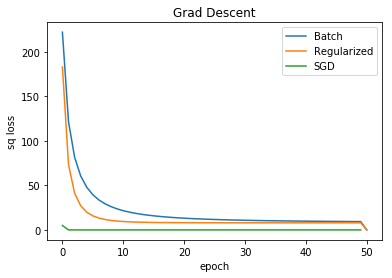

In [49]:
def main():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('hw1-sgd/data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

    th, batch_loss = batch_grad_descent(X_train, y_train, 0.01, 50)
    th, reg_loss = regularized_grad_descent(X_train, y_train, 0.01, 15, 50)
    th, sgd_loss = stochastic_grad_descent(X_train, y_train, 0.01, 1, 50)
    
    plt.plot(range(len(batch_loss)), batch_loss, label='Batch')
    plt.plot(range(len(reg_loss)), reg_loss, label='Regularized')
    plt.plot(range(sgd_loss.shape[0]), [np.average(l) for l in sgd_loss], label='SGD')
    
    plt.xlabel('epoch')
    plt.ylabel('sq loss')
    plt.title("Grad Descent")
    plt.legend()
    plt.show()
    
if __name__ == "__main__":
    main()